# Feature analysis for lung tumor histology prediction (LIDC cohort)

In this notebook, we investigate the selected radiomic and topological features tumor histology prediction. We start by setting the working directory and importing the required libraries.

In [1]:
# Set working directory (change accordingly)
workdir = "/home/robin/Documents/Stanford_VSR/NMI/TDA_Lung_Histology"

import os
import sys
os.chdir(workdir)
sys.path.insert(0, os.path.join(workdir, "Functions"))

In [2]:
# Topological feature extraction
import TDAfeatures as tf

# Handling arrays and data frames
import numpy as np
import pandas as pd 

# Functions constructing for final chosen pipeline
from sklearn.impute import SimpleImputer # for imputing missing values
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer # preprocessing features
from sklearn.base import BaseEstimator, TransformerMixin # base functions for building custom sklearn transformers
from pymrmr import mRMR # minimum redundancy maximum relevance feature selection
from sklearn.linear_model import LogisticRegression, LinearRegression # linear models
from sklearn.pipeline import make_pipeline # make pipeline combining preprocessing and ML models

# plotting
import matplotlib.pyplot as plt

We now construct the pipeline that will be used for classification. **Our final chosen model to study is the a voting ensemble using linear/logistic regression models as base models** (depending on the type of outcome). Since no retraining is performed after constructing the base classifiers, we will study the base classifiers for analysis.

In [3]:
# Construct sklearn compatible mrmr feature selector
class mrmrSelector(BaseEstimator, TransformerMixin):
    # Class Constructor 
    def __init__(self, n_bins=5, n_features=10, method="MIQ"):
        super().__init__()
        self.cols = None
        self.discretizer = None
        self.n_bins = n_bins
        self.n_features = n_features
        self.method = method
    
    def fit(self, X, y):
        self.discretizer = KBinsDiscretizer(n_bins=self.n_bins, encode="ordinal", strategy="uniform").fit(X)
        temp = pd.DataFrame(np.column_stack([y, self.discretizer.transform(X)]))
        temp.columns = [str(i) for i in range(temp.shape[1])]
        self.cols =  [int(i) - 1 for i in mRMR(temp, self.method, self.n_features)]
        
        return self
        
    def transform(self, X):
        
        return self.discretizer.transform(X)[:,self.cols]
    
# Construct pipelines
pipe_rad_class = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(), LogisticRegression(random_state=42))
pipe_top_class = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(), LogisticRegression(random_state=42))
pipe_rad_reg = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(), LinearRegression())
pipe_top_reg = make_pipeline(SimpleImputer(), MinMaxScaler(), mrmrSelector(), LinearRegression())

## Loading the data

We start by loading the meta data (including the annotated tumor malignancy), the radiomic features, and the topological features. The meta data also includes semantic features that were manually annotated by expert radiologists, which they consecutively used for their malignancy prediction.

### Loading the malignancy scores and semantic features

In [4]:
meta = pd.read_csv(os.path.join("Features", "LIDC", "Meta.csv"), index_col=0)
meta.head(5)

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy,Contrast
LIDC-IDRI-0463_nodule0,2.75,1.0,6.0,3.75,4.50,1.50,1.25,5.00,2.50,N
LIDC-IDRI-0463_nodule1,3.50,1.0,3.0,3.50,4.75,2.00,1.75,5.00,1.00,N
LIDC-IDRI-0196_nodule0,4.25,1.0,6.0,2.25,3.00,2.25,2.50,5.00,4.25,N
LIDC-IDRI-0053_nodule0,5.00,1.0,6.0,4.25,4.75,2.25,1.50,5.00,4.00,Y
LIDC-IDRI-0053_nodule1,4.50,1.0,6.0,3.50,4.25,1.50,1.50,4.75,3.25,Y


### Loading the accurate diagnosis data
The malignancy scores assigned by the expert radiologist is a best guess, based on the semantic features above which they manually and visually infer from the scan. Unfortunately, their assigned outcome does not always reflect the true histology of the tumor.

For a small number of patients, LIDC includes more accurate biological diagnoses, which were obtained through one of the following assessments:

    review of radiological images to show two years of stable nodule
    biopsy
    surgical resection
    progression or response

We will use these outcomes to evaluate our features for benign vs. malignant classification, and see how this compares to the radiologist predictions. Similar to the SF/PA cohort, we will only include primary lung tumors. The diagnosis data is loaded as follows.

In [5]:
diagnosis = pd.DataFrame()

diagnosis_temp = pd.read_excel(os.path.join("Features", "LIDC", "Diagnosis.xls"), index_col=0)

for p in diagnosis_temp.index:
    for idx, c in enumerate(diagnosis_temp.columns):
        if diagnosis_temp.loc[p, c] == " " or diagnosis_temp.loc[p, c] != diagnosis_temp.loc[p, c]:
            break
        if c.startswith("Nodule") and not "Method" in c \
            and diagnosis_temp.loc[p, c] not in [0, 3] and diagnosis_temp.loc[p,:][idx + 1] != 0:
            pnod = p + "_nodule" + str(int(c[7]) - 1)
            this_diagnosis = "Benign" if diagnosis_temp.loc[p, c] == 1 else "Malignant"
            diagnosis.loc[pnod, "Diagnosis"] = this_diagnosis
            
del diagnosis_temp

diagnosis.head(5)

,Diagnosis
LIDC-IDRI-0071_nodule0,Benign
LIDC-IDRI-0072_nodule0,Benign
LIDC-IDRI-0090_nodule0,Malignant
LIDC-IDRI-0100_nodule0,Benign
LIDC-IDRI-0138_nodule0,Malignant


### Loading the radiomic features

In [6]:
X_rad = pd.read_csv(os.path.join("Features", "LIDC", "Radiomic.csv"), index_col=0, skipfooter=1, engine="python")
X_rad =  X_rad.loc[:,[c for c in X_rad.columns if c.startswith("original")]]
X_rad.index = [pnod.split("_")[0] + "_nodule" + pnod.split("_")[1] for pnod in X_rad.index]
X_rad.head(5)

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
LIDC-IDRI-0001_nodule0,0.972560,0.242197,7.854413,32.429873,35.227830,44.011362,45.617979,48.456166,5382.208333,31.539994,...,0.025437,0.002318,0.321236,219.230898,0.001316,0.464981,0.001207,3161.376595,0.327654,1.274576
LIDC-IDRI-0002_nodule0,0.918731,0.643298,22.362177,34.761745,48.166378,42.190046,45.398238,51.176166,14167.833333,31.936697,...,1.215724,0.025196,0.147028,33.599233,0.003301,2.338047,0.001018,1020.843650,0.056218,0.912244
LIDC-IDRI-0003_nodule0,0.778668,0.187225,5.949320,31.776383,31.016125,32.015621,38.832976,39.673669,2509.250000,24.743257,...,0.336389,0.024771,0.253988,59.521751,0.005994,0.538749,0.003743,1916.280021,0.090890,4.002751
LIDC-IDRI-0003_nodule1,0.815524,0.238987,6.960832,29.126416,29.000000,30.149627,37.696154,37.696154,3208.833333,23.753283,...,0.037370,0.005136,0.356975,157.554000,0.002917,0.377635,0.002130,2523.362731,0.341993,1.578101
LIDC-IDRI-0003_nodule2,0.686744,0.248045,3.243108,13.074666,15.000000,10.049876,15.297059,15.297059,251.083333,8.978947,...,0.042920,0.024101,0.588595,164.272045,0.021502,0.178335,0.012622,3295.582062,1.244363,5.867940


### Extracting the topological features

The topological features are not stored. Rather, we can quickly obtain them through the stored diagrams, which may also be used to potentially explore other machine learning models. We start by loading these diagrams.

In [7]:
dgms = {"img_sub":{}, "img_sup":{}, "img_box_sub":{}, "img_box_sup":{}, "point_cloud":{}}

for patient in os.listdir(os.path.join("Diagram", "LIDC")):
    for nod in os.listdir(os.path.join("Diagram", "LIDC", patient)):
        
        if len(os.listdir(os.path.join("Diagram", "LIDC", patient, nod, "consensus"))) != 15:
            continue
        
        for dgm in os.listdir(os.path.join("Diagram", "LIDC", patient, nod, "consensus")):
        
            dgmtype = "_".join(dgm.split("_")[:-1])
            dgmdim = dgm.split("_")[-1].replace(".npy", "")
            dgms[dgmtype].setdefault(patient + "_" + nod, {})
            dgms[dgmtype][patient + "_" + nod][dgmdim] = \
                np.load(os.path.join("Diagram", "LIDC", patient, nod, "consensus", dgm))

We can now obtain our data of topological feature vectors as follows.

In [8]:
X_top = dict()

for dgm_type in dgms.keys():
    for patient in dgms[dgm_type].keys():
        
        X_top[patient] = X_top.setdefault(patient, {})
        
        for dim in dgms[dgm_type][patient].keys():
            
            features = tf.persistence_statistics(dgms[dgm_type][patient][dim])
            for key in features.keys():
                new_key = dgm_type + "_" + dim + "_" + key
                X_top[patient][new_key] = features[key]
            
            del features

X_top = pd.DataFrame(X_top).transpose()            
X_top.head(5)

,img_sub_dgm0_min_birth,img_sub_dgm0_no_infinite_lifespans,img_sub_dgm0_no_finite_lifespans,img_sub_dgm0_mean_finite_midlifes,img_sub_dgm0_mean_finite_lifespans,img_sub_dgm0_std_finite_midlifes,img_sub_dgm0_std_finite_lifespans,img_sub_dgm0_skew_finite_midlifes,img_sub_dgm0_skew_finite_lifespans,img_sub_dgm0_kurtosis_finite_midlifes,...,point_cloud_dgm2_kurtosis_finite_lifespans,point_cloud_dgm2_median_finite_midlifes,point_cloud_dgm2_median_finite_lifespans,point_cloud_dgm2_Q1_finite_midlifes,point_cloud_dgm2_Q1_finite_lifespans,point_cloud_dgm2_Q3_finite_midlifes,point_cloud_dgm2_Q3_finite_lifespans,point_cloud_dgm2_IQR_finite_midlifes,point_cloud_dgm2_IQR_finite_lifespans,point_cloud_dgm2_entropy_finite_lifespans
LIDC-IDRI-0001_nodule0,-776.0,1.0,216.0,-326.652778,83.111111,219.786196,87.662688,0.573147,1.616111,-0.703041,...,3.139433,2.768479,0.195204,2.659193,0.131184,2.955781,0.269722,0.296587,0.138538,0.472341
LIDC-IDRI-0002_nodule0,-948.0,1.0,398.0,-811.459799,22.879397,83.747547,24.781772,0.978962,2.454748,0.494789,...,0.242792,3.741164,0.140829,2.607521,0.041936,3.985887,0.521858,1.378366,0.479923,0.270699
LIDC-IDRI-0003_nodule0,-889.0,1.0,95.0,-774.715789,38.884211,61.542824,36.534875,1.400075,1.178579,2.737891,...,-0.668048,6.906821,0.211680,5.730269,0.123865,7.870091,2.121483,2.139822,1.997618,0.300439
LIDC-IDRI-0003_nodule1,-747.0,1.0,116.0,-468.711207,86.525862,167.809996,69.672938,1.681818,0.936959,2.003117,...,-0.666688,2.768688,0.208934,2.446540,0.195399,4.243754,2.820393,1.797214,2.624994,0.267167
LIDC-IDRI-0003_nodule2,-698.0,1.0,23.0,-505.108696,141.869565,86.484348,109.010292,-0.240412,0.812679,-0.766613,...,-0.666830,2.540116,0.080232,2.533205,0.066409,2.978636,0.924068,0.445432,0.857659,0.300841


Some columns of our topological features are known to be constant in advance. For example, the filtration constructed from the image with boundary pixels will always end at one connected component with no higher-dimensional holes. We will discard these from our topological features. Notice that indeed only columns from which we know in advance they are constant are discarded below. 

In [9]:
constant_features = []

for col in X_top.columns:
    values = np.unique(X_top[col])
    values = values[~np.isnan(values)]
    if len(values) == 1:
        constant_features.append(col)
        
X_top = X_top.drop(columns=constant_features)

print("Discarded features (with constant values):")
print("\n")
for f in constant_features:
    print(f)

Discarded features (with constant values):


img_box_sub_dgm0_no_infinite_lifespans
img_box_sub_dgm1_no_infinite_lifespans
img_box_sub_dgm2_no_infinite_lifespans
img_box_sup_dgm0_no_infinite_lifespans
img_box_sup_dgm1_no_infinite_lifespans
img_box_sup_dgm2_no_infinite_lifespans
point_cloud_dgm0_min_birth
point_cloud_dgm0_no_infinite_lifespans
point_cloud_dgm1_no_infinite_lifespans
point_cloud_dgm2_no_infinite_lifespans


### Final preparations

Finally, we ensure that the indexing of all dataframes is consistent.

In [10]:
missing_rad = np.setdiff1d(meta.index, X_rad.index)
missing_top = np.setdiff1d(meta.index, X_top.index)
patients = np.setdiff1d(meta.index, np.concatenate([missing_rad, missing_top]))
diagnosis = diagnosis.loc[np.intersect1d(diagnosis.index, patients),:]

print("Number of nodules: " + str(len(patients)) +
      " (" + str(len(meta.index) - len(patients)) + " omitted from study)")
print("Accurate diagnosis for " + str(len(diagnosis.index)) + " nodules")
print("Number of radiomic features: " + str(X_rad.shape[1]) + 
      " (missing rows for " + str(len(missing_rad)) + " nodules)")
print("Number of topological features: " + str(X_top.shape[1]) 
      + " (missing rows for " + str(len(missing_top)) + " nodules)")

meta = meta.loc[patients,:]
X_rad =  X_rad.loc[patients,:]
X_top = X_top.loc[patients,:]

Number of nodules: 2544 (81 omitted from study)
Accurate diagnosis for 54 nodules
Number of radiomic features: 105 (missing rows for 1 nodules)
Number of topological features: 290 (missing rows for 80 nodules)


## Analyzing features for tumor type prediction

We now analyze the feature importance of and correlation between radiomic and topological features selected.

In [11]:
with_contrast = [p for p in meta.index if meta.loc[p, "Contrast"] == "Y"]
without_contrast = [p for p in meta.index if meta.loc[p, "Contrast"] == "N"]

We use the following function to plot feature correlations and importances.

In [29]:
def plot_features(model_rad, model_top):
    coef_rad = model_rad._final_estimator.coef_ if type(model_top._final_estimator) == LinearRegression \
                else model_rad._final_estimator.coef_[0]
    I_rad = np.argsort(np.abs(coef_rad))[::-1]
    coef_top = model_top._final_estimator.coef_ if type(model_top._final_estimator) == LinearRegression \
                else model_rad._final_estimator.coef_[0]
    I_top = np.argsort(np.abs(coef_top))[::-1]
    coef_rad = coef_rad[I_rad]
    coef_top = coef_top[I_top]
    features_rad = X_rad.columns[model_rad['mrmrselector'].cols][I_rad]
    features_top = X_top.columns[model_top['mrmrselector'].cols][I_top]
    
    cor_matrix = np.zeros([len(features_rad), len(features_top)])
    for idx1, f1 in enumerate(features_rad):
        for idx2, f2 in enumerate(features_top):
            cor_matrix[idx1, idx2] = pd.concat([X_rad.loc[:,f1], X_top.loc[:,f2]], axis=1).corr().iloc[0, 1]
    labels_rad = [features_rad[idx] + ' (' + str(round(coef_rad[idx], 2)) + ')' for idx in range(len(features_rad))]
    labels_top = [features_top[idx] + ' (' + str(round(coef_top[idx], 2)) + ')' for idx in range(len(features_rad))]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.matshow(cor_matrix, cmap=plt.cm.RdBu, vmin=-1, vmax=1)
    ax.set_xticks(range(len(features_top)))
    ax.set_xticklabels(labels_top, rotation=90)
    ax.set_yticks(range(len(features_rad)))
    ax.set_yticklabels(labels=labels_rad)
    fig.colorbar(cax)
    plt.show()

### Comparing features for malignancy prediction (regression + all nodules)

We analyze the selected features for malignancy prediction via regression.

#### Images with contrast

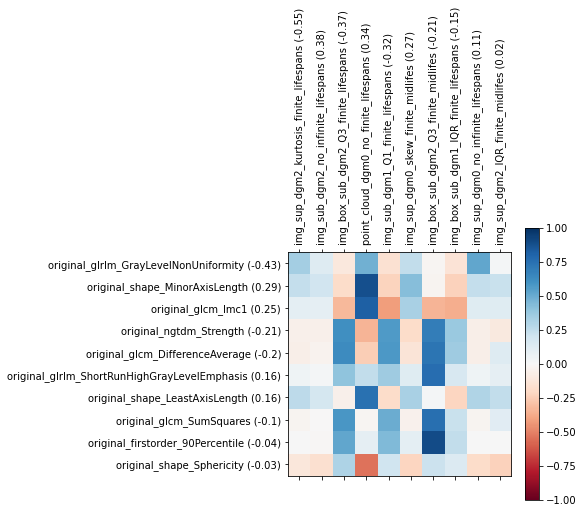

In [30]:
model_rad = pipe_rad_reg.fit(X=X_rad.loc[with_contrast,], y=meta.loc[with_contrast, "malignancy"])
model_top = pipe_top_reg.fit(X=X_top.loc[with_contrast,], y=meta.loc[with_contrast, "malignancy"])
plot_features(model_rad, model_top)

#### Images without contrast

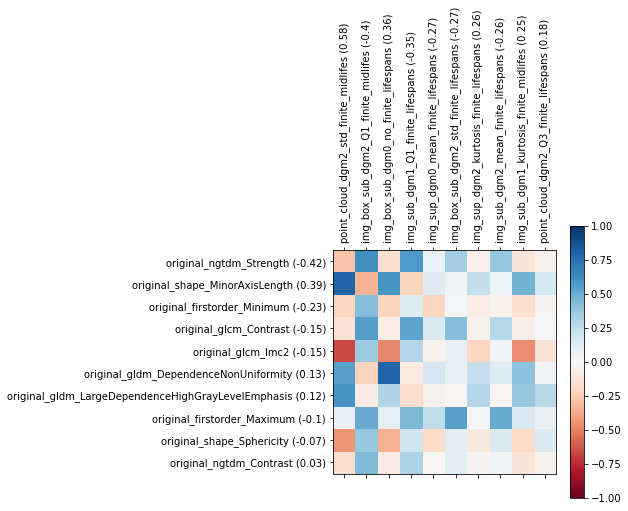

In [31]:
model_rad = pipe_rad_reg.fit(X=X_rad.loc[without_contrast,], y=meta.loc[without_contrast, "malignancy"])
model_top = pipe_top_reg.fit(X=X_top.loc[without_contrast,], y=meta.loc[without_contrast, "malignancy"])
plot_features(model_rad, model_top)

### Comparing features for malignancy prediction (classification + nodules with diagnosis only)

We analyze the selected features for malignancy prediction via classification, restricted to the nodules for which accurate diagnosis is available.

In [32]:
diagnosis_with = np.intersect1d(with_contrast, diagnosis.index)
diagnosis_without = np.intersect1d(without_contrast, diagnosis.index)
y_diagnosis_with = [0 if d == "Benign" else 1 for d in diagnosis.loc[diagnosis_with, "Diagnosis"]]
y_diagnosis_without = [0 if d == "Benign" else 1 for d in diagnosis.loc[diagnosis_without, "Diagnosis"]]

#### Images with contrast

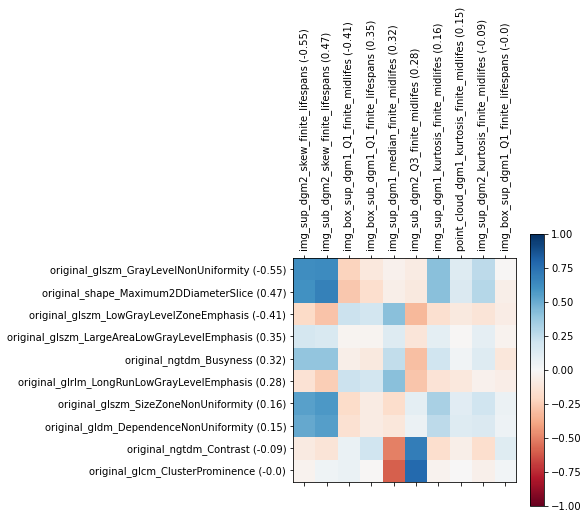

In [33]:
model_rad = pipe_rad_class.fit(X=X_rad.loc[diagnosis_with,], y=y_diagnosis_with)
model_top = pipe_top_class.fit(X=X_top.loc[diagnosis_with,], y=y_diagnosis_with)
plot_features(model_rad, model_top)

#### Images without contrast

C:\Users\robin\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_discretization.py:257: UserWarning: Feature 41 is constant and will be replaced with 0.
  warnings.warn(
C:\Users\robin\anaconda3\envs\ml\lib\site-packages\sklearn\preprocessing\_discretization.py:257: UserWarning: Feature 101 is constant and will be replaced with 0.
  warnings.warn(


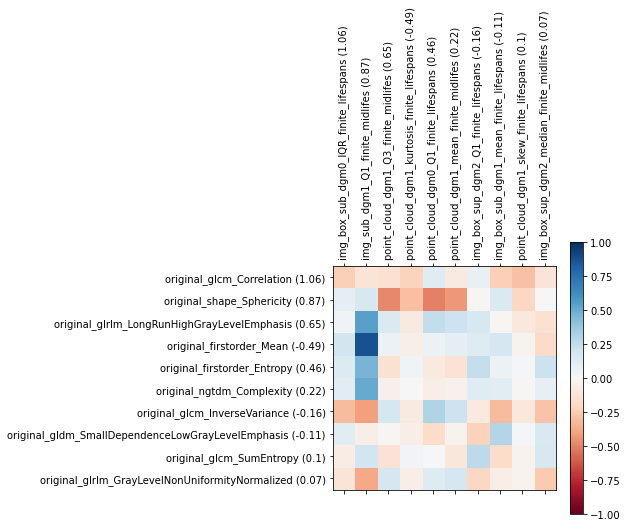

In [34]:
model_rad = pipe_rad_class.fit(X=X_rad.loc[diagnosis_without,], y=y_diagnosis_without)
model_top = pipe_top_class.fit(X=X_top.loc[diagnosis_without,], y=y_diagnosis_without)
plot_features(model_rad, model_top)